<a href="https://colab.research.google.com/github/arminerika/Tweet-Bullying-Classifier/blob/main/CS4200_Class_Project_AEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyberbullying Classification with BERT
#### By: Armin Erika Polanco
#### This notebook fine-tunes BERT on a labeled cyberbullying tweet dataset using Hugging Face Transformers.
---

## 📦 Data Loading & Setup

📃 Install Dependencies

In [1]:
!pip install -q transformers datasets scikit-learn pandas matplotlib seaborn wordcloud gradio
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

📥 Import Libraries

In [2]:
import re, torch, pickle
import pandas as pd, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

## 🧼 Load, Clean, Encode, Tokenize and Train

In [4]:
# Load data
df = pd.read_csv("cyberbullying_tweets.csv")

# Define a function to clean tweets
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)           # Remove @mentions
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    text = re.sub(r'[^a-zA-Z ]', '', text)     # Remove non-alphabetic characters
    return text.strip()

df['text_clean'] = df['tweet_text'].apply(clean_tweet)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])
label_list = list(label_encoder.classes_)

🔠 Train-Test Split & Tokenize with BERT Tokenizer

In [5]:
# Split dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Load pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize texts; using dynamic padding (the DataCollator will pad each batch to the longest sequence in that batch)
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': list(train_labels)
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': list(test_labels)
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

🤖 Load Model & Configure Training

In [6]:
# Load BERT model for sequence classification with number of labels based on our dataset
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label_list)
)

# Set the directory to save the model consistently
SAVE_DIR = "cyberbullying-bert-model"

# Configure training using TrainingArguments
training_args = TrainingArguments(
    output_dir=SAVE_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Train with Hugging Face Trainer

In [7]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.449500,0.378453,0.855750
2,0.318300,0.418123,0.859000
3,0.243700,0.503770,0.853444


TrainOutput(global_step=14310, training_loss=0.33719311813471786, metrics={'train_runtime': 2540.4799, 'train_samples_per_second': 45.054, 'train_steps_per_second': 5.633, 'total_flos': 3.011650986256589e+16, 'train_loss': 0.33719311813471786, 'epoch': 3.0})

🔐 Save Model and Label Encoder



In [8]:
# Save the fine-tuned model and tokenizer
trainer.save_model(SAVE_DIR)

# Save the label encoder
with open("cyberbullying_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Model, tokenizer, and label encoder saved successfully.")

Model, tokenizer, and label encoder saved successfully.


## 📓 Testing Cyberbullying Classifier

Step 1: Load the Model and Tokenizer

In [9]:
# Load the trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained(SAVE_DIR)
tokenizer = BertTokenizer.from_pretrained(SAVE_DIR)

# Put model on correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Load the label encoder
with open("cyberbullying_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

 Step 2: Define Sample Tweets

In [10]:
# Sample tweets (demo-friendly)
sample_tweets = [
    "You're too old to be using social media like this.",
    "I don't think someone of your background would understand.",
    "This is not bullying at all, just my opinion.",
    "Women should stay out of this field.",
    "You're such a loser, nobody likes you.",
    "People of that religion are always causing trouble.",
    "Congratulations on your graduation!"
    "How are you still failing this class? Seriously.",
    "Honestly, I just mute people like that.",
    "He probably didn’t get hired because of where he’s from.",
    "Wow, that’s what you wore to a job interview?",
    "She’s good… for a girl.",
    "Old people shouldn’t try to use TikTok.",
    "You’re so sensitive, it was just a joke.",
    "Imagine thinking like that in 2025.",
    "That ethnicity  is always causing problems online.",
    "It's not mean, I'm just being honest."
]

Step 3: Tokenize the Input


In [11]:
# Tokenize the sample tweets using the same tokenizer used during training
inputs = tokenizer(sample_tweets, truncation=True, padding=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

Step 4: Run the Predictions

In [12]:
# Predict with model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()
labels = label_encoder.inverse_transform(preds)

Step 5: Display the Results

In [13]:
# Display predictions with confidence score
print("---- Cyberbullying Classification Demo ----\n")
for tweet, label, prob in zip(sample_tweets, labels, probs.max(dim=1).values.cpu().numpy()):
    print(f"Tweet: {tweet}\nPredicted Label: {label} (confidence: {prob:.2f})\n")

---- Cyberbullying Classification Demo ----

Tweet: You're too old to be using social media like this.
Predicted Label: other_cyberbullying (confidence: 0.89)

Tweet: I don't think someone of your background would understand.
Predicted Label: other_cyberbullying (confidence: 0.72)

Tweet: This is not bullying at all, just my opinion.
Predicted Label: other_cyberbullying (confidence: 0.95)

Tweet: Women should stay out of this field.
Predicted Label: gender (confidence: 0.44)

Tweet: You're such a loser, nobody likes you.
Predicted Label: other_cyberbullying (confidence: 0.83)

Tweet: People of that religion are always causing trouble.
Predicted Label: religion (confidence: 0.83)

Tweet: Congratulations on your graduation!How are you still failing this class? Seriously.
Predicted Label: not_cyberbullying (confidence: 0.99)

Tweet: Honestly, I just mute people like that.
Predicted Label: other_cyberbullying (confidence: 0.91)

Tweet: He probably didn’t get hired because of where he’s fro

## 📊 Charts & Stuff

In [14]:
with open("cyberbullying_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Use trainer predict to safely batch predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

📊 Label Distribution in Test Set

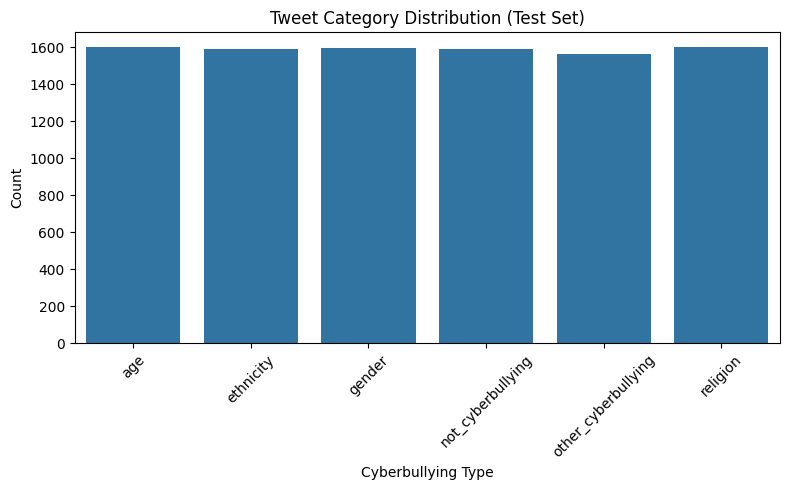

In [15]:
# Plot: Test Set Label Distribution
test_labels_named = label_encoder.inverse_transform(y_true)
plt.figure(figsize=(8,5))
sns.countplot(x=test_labels_named, order=label_encoder.classes_)

plt.title("Tweet Category Distribution (Test Set)")
plt.xlabel("Cyberbullying Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("test_label_distribution.png")
plt.show()

📉 Confusion Matrix

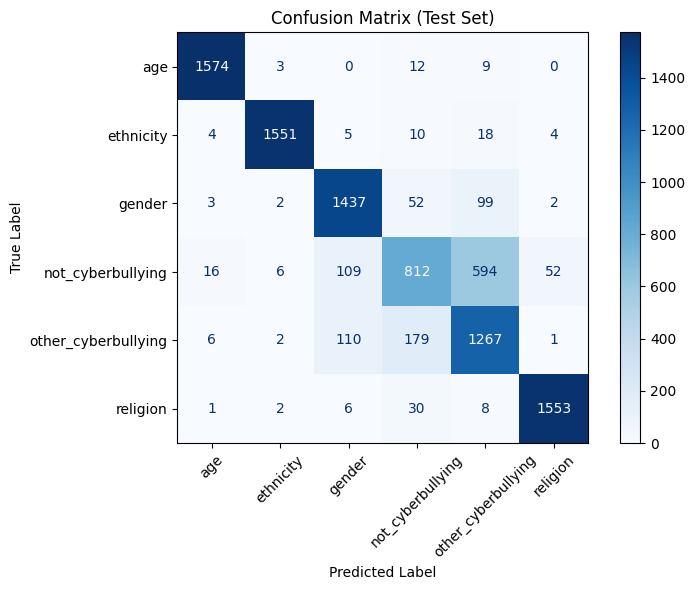

In [16]:
# Plot: Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=label_list, cmap="Blues", ax=ax
)

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

📈 Per-Class Precision, Recall, and F1-score

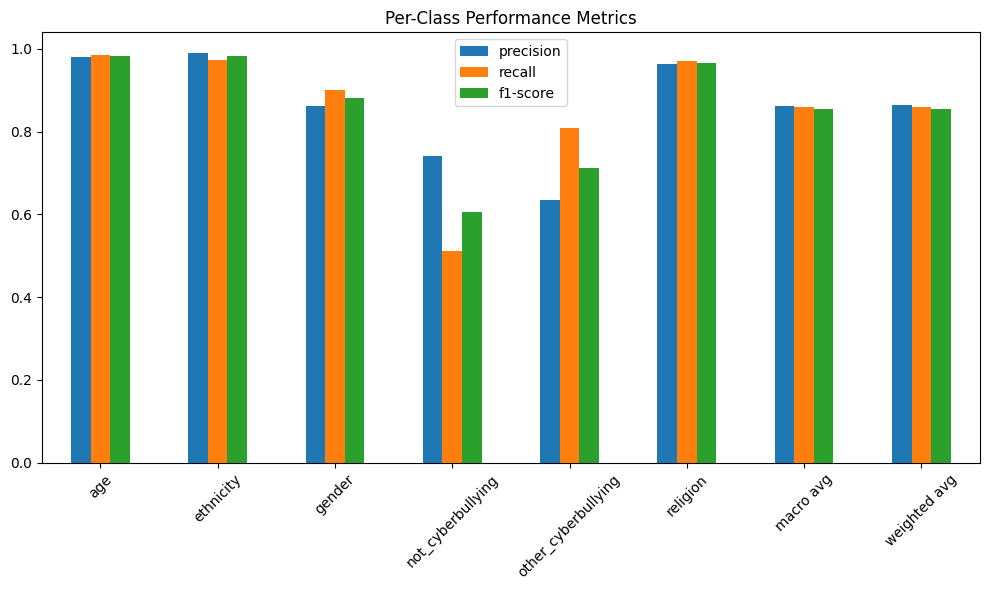

In [17]:
# Plot: Per-Class Performance Metrics (Precision, Recall, F1)
report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

df_report = pd.DataFrame(report_dict).transpose().drop("accuracy")
df_report[["precision", "recall", "f1-score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Per-Class Performance Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("classification_metrics.png")
plt.show()

☁ Word Cloud (Most Frequent Words)

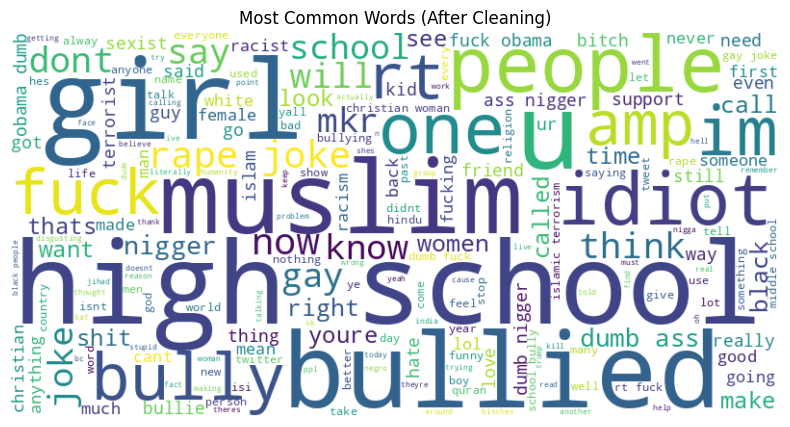

In [18]:
# Combine all cleaned text
all_text = ' '.join(df['text_clean'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words (After Cleaning)")
plt.show()

## 📲 Gradio App Demo

In [19]:
!pip install gradio --quiet

In [20]:
import os
os.environ["GRADIO_TEMP_DIR"] = "/tmp"  # Prevents permission issues

In [21]:
import gradio as gr

# Load model and supporting components
model = BertForSequenceClassification.from_pretrained(SAVE_DIR)
tokenizer = BertTokenizer.from_pretrained(SAVE_DIR)

with open("cyberbullying_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Define inference function
def classify_tweet(text):
    if not text.strip():
        return "Please enter a tweet."

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = F.softmax(outputs.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    label = label_encoder.inverse_transform([pred])[0]
    confidence = probs[0][pred].item()
    return f"Predicted Label: {label} (Confidence: {confidence:.2%})"

gr.Interface(
    fn=classify_tweet,
    inputs=gr.Textbox(lines=2, placeholder="Type or paste a tweet here..."),
    outputs="text",
    examples=[
        "You're too old to be using social media like this.",
        "People of that religion are always causing trouble.",
        "This is not bullying at all, just my opinion.",
        "Women should stay out of this field.",
        "Congratulations on your graduation!"
    ],
    title="Cyberbullying Classifier 🤖",
    description="Enter a tweet to classify its cyberbullying category (age, gender, ethnicity, etc.) or not."
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e1f934f945fc560a6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## SAVE ALL THINGS

In [22]:
!zip -r cyberbullying-bert-model.zip cyberbullying-bert-model

  adding: cyberbullying-bert-model/ (stored 0%)
  adding: cyberbullying-bert-model/config.json (deflated 54%)
  adding: cyberbullying-bert-model/checkpoint-4770/ (stored 0%)
  adding: cyberbullying-bert-model/checkpoint-4770/config.json (deflated 54%)
  adding: cyberbullying-bert-model/checkpoint-4770/rng_state.pth (deflated 25%)
  adding: cyberbullying-bert-model/checkpoint-4770/model.safetensors (deflated 7%)
  adding: cyberbullying-bert-model/checkpoint-4770/training_args.bin (deflated 52%)
  adding: cyberbullying-bert-model/checkpoint-4770/vocab.txt (deflated 53%)
  adding: cyberbullying-bert-model/checkpoint-4770/optimizer.pt (deflated 18%)
  adding: cyberbullying-bert-model/checkpoint-4770/trainer_state.json (deflated 57%)
  adding: cyberbullying-bert-model/checkpoint-4770/special_tokens_map.json (deflated 42%)
  adding: cyberbullying-bert-model/checkpoint-4770/scheduler.pt (deflated 55%)
  adding: cyberbullying-bert-model/checkpoint-4770/tokenizer_config.json (deflated 75%)
  ad